Esteban Castañeda Blanco C01795

Israel López Vallecillo C04396

Daniel Lizano Morales C04285

Ariel Solís Monge B97664

In [1]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [2]:
unlabeled_set_size = 0.5
labeled_train_absolute_set_size = 0.35
labeled_test_absolute_set_size = round(1 - (labeled_train_absolute_set_size + unlabeled_set_size), 2)

labeled_train_relative_set_size = round((labeled_train_absolute_set_size / (1 - unlabeled_set_size)), 2)
labeled_test_relative_set_size = 1 - labeled_train_relative_set_size

In [3]:
base_dir = os.path.join('Plant_leave_diseases_dataset', 'original')
os.makedirs('best_models', exist_ok=True)
model_save_path = \
    os.path.join('best_models', f'h1_{int(unlabeled_set_size*100)}-{int(labeled_train_absolute_set_size*100)}-{int(labeled_test_absolute_set_size*100)}_classifierA.pth')

## Datasets and dataloaders

In [4]:
data_transforms = {
    'all': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

In [5]:
full_dataset = datasets.ImageFolder(base_dir, transform=data_transforms['all'])

In [6]:
indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

In [7]:
#Obtenemos el 20% de los datos 
train_val_indices, _ = train_test_split(indices, test_size=unlabeled_set_size, stratify=labels, random_state=42)

#Obtenemos las etiquetas de los datos de entrenamiento
train_val_labels = [labels[i] for i in train_val_indices]

#dividir el 20% en 10% de entrenamiento y 10% de validación
train_indices, val_indices = train_test_split(train_val_indices, test_size=labeled_test_relative_set_size, stratify=train_val_labels, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_loader.dataset)}")

Número de imágenes en el conjunto de entrenamiento: 21520
Número de imágenes en el conjunto de validación: 9223


## Function definitions

In [9]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [10]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    
    return model

In [11]:
def evaluate_model(model_path, dataloader, device):
    model = models.efficientnet_b2(pretrained=False)
    new_in_channels = 1
    original_conv1 = model.features[0][0]

    new_conv1 = nn.Conv2d(
        in_channels=new_in_channels,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias
    )
    with torch.no_grad():
        if new_in_channels == 1:
            new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
        else:
            new_conv1.weight[:, :3] = original_conv1.weight
            if new_in_channels > 3:
                for i in range(3, new_in_channels):
                    new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)
    model.features[0][0] = new_conv1
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names=dataloader.dataset.dataset.classes)
    class_names = dataloader.dataset.dataset.classes
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print(f'Overall Accuracy: {accuracy:.4f}')
    print("\nMetrics by Class:")
    print("{:<20} {:<10} {:<10} {:<10}".format("Class", "Accuracy", "Precision", "Recall"))
    print("="*50)
    for class_name, class_accuracy, class_precision, class_recall in zip(class_names, class_accuracies, precision, recall):
        print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(class_name, class_accuracy, class_precision, class_recall))
    
    return accuracy

## CNN Classifier

In [12]:
# Set up of the device
if torch.backends.mps.is_available():
    device = torch.device("mps")#tqm
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
model = models.efficientnet_b2()

# Modify the first convolutional layer to accept a different number of input channels (e.g., 1 instead of 3)
new_in_channels = 1  # Change this to the desired number of input channels
original_conv1 = model.features[0][0]

new_conv1 = nn.Conv2d(
    in_channels=new_in_channels,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias
)

# Initialize the weights of the new conv layer
with torch.no_grad():
    if new_in_channels == 1:
        # Average the weights of the original conv layer across the input channels
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
    else:
        # Initialize weights by repeating the mean weights or use a different strategy
        new_conv1.weight[:, :3] = original_conv1.weight
        if new_in_channels > 3:
            for i in range(3, new_in_channels):
                new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)

# Replace the first convolutional layer in the model
model.features[0][0] = new_conv1

# Print the modified first convolutional layer
print("Modified first conv layer:", model.features[0][0])
# model._conv_stem = nn.Conv2d(1, model._conv_stem.out_channels, kernel_size=model._conv_stem.kernel_size, stride=model._conv_stem.stride, padding=model._conv_stem.padding, bias=False)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: mps
Modified first conv layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


### Training

In [13]:
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=30, patience=5)


100%|██████████| 673/673 [06:23<00:00,  1.75it/s]


Epoch 1/30
Train Loss: 2.4847 Acc: 0.3286
Val Loss: 1.6194 Acc: 0.5185


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 2/30
Train Loss: 1.3325 Acc: 0.5987
Val Loss: 0.9025 Acc: 0.7250


100%|██████████| 673/673 [06:14<00:00,  1.80it/s]


Epoch 3/30
Train Loss: 0.8835 Acc: 0.7180
Val Loss: 0.7214 Acc: 0.7719


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 4/30
Train Loss: 0.6415 Acc: 0.7929
Val Loss: 0.5735 Acc: 0.8229


100%|██████████| 673/673 [06:14<00:00,  1.80it/s]


Epoch 5/30
Train Loss: 0.5186 Acc: 0.8315
Val Loss: 0.4404 Acc: 0.8545


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 6/30
Train Loss: 0.4297 Acc: 0.8572
Val Loss: 0.4638 Acc: 0.8486


100%|██████████| 673/673 [06:14<00:00,  1.80it/s]


Epoch 7/30
Train Loss: 0.3741 Acc: 0.8754
Val Loss: 0.3906 Acc: 0.8747


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 8/30
Train Loss: 0.3219 Acc: 0.8930
Val Loss: 0.3752 Acc: 0.8803


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 9/30
Train Loss: 0.2869 Acc: 0.9023
Val Loss: 0.3607 Acc: 0.8885


100%|██████████| 673/673 [06:14<00:00,  1.80it/s]


Epoch 10/30
Train Loss: 0.2493 Acc: 0.9161
Val Loss: 0.3224 Acc: 0.8941


100%|██████████| 673/673 [06:14<00:00,  1.80it/s]


Epoch 11/30
Train Loss: 0.2279 Acc: 0.9227
Val Loss: 0.3115 Acc: 0.9042


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 12/30
Train Loss: 0.2001 Acc: 0.9314
Val Loss: 0.2986 Acc: 0.9045


100%|██████████| 673/673 [06:17<00:00,  1.78it/s]


Epoch 13/30
Train Loss: 0.1839 Acc: 0.9381
Val Loss: 0.2815 Acc: 0.9129


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 14/30
Train Loss: 0.1688 Acc: 0.9427
Val Loss: 0.3404 Acc: 0.8981


100%|██████████| 673/673 [06:14<00:00,  1.80it/s]


Epoch 15/30
Train Loss: 0.1509 Acc: 0.9482
Val Loss: 0.3618 Acc: 0.8898


100%|██████████| 673/673 [06:14<00:00,  1.80it/s]


Epoch 16/30
Train Loss: 0.1357 Acc: 0.9550
Val Loss: 0.2669 Acc: 0.9201


100%|██████████| 673/673 [06:14<00:00,  1.80it/s]


Epoch 17/30
Train Loss: 0.1253 Acc: 0.9579
Val Loss: 0.2881 Acc: 0.9164


100%|██████████| 673/673 [06:20<00:00,  1.77it/s]


Epoch 18/30
Train Loss: 0.1223 Acc: 0.9585
Val Loss: 0.2853 Acc: 0.9187


100%|██████████| 673/673 [06:20<00:00,  1.77it/s]


Epoch 19/30
Train Loss: 0.0965 Acc: 0.9661
Val Loss: 0.2694 Acc: 0.9219


100%|██████████| 673/673 [06:17<00:00,  1.78it/s]


Epoch 20/30
Train Loss: 0.1017 Acc: 0.9661
Val Loss: 0.2838 Acc: 0.9176


100%|██████████| 673/673 [06:17<00:00,  1.78it/s]


Epoch 21/30
Train Loss: 0.0886 Acc: 0.9688
Val Loss: 0.2439 Acc: 0.9293


100%|██████████| 673/673 [06:20<00:00,  1.77it/s]


Epoch 22/30
Train Loss: 0.0912 Acc: 0.9690
Val Loss: 0.3111 Acc: 0.9181


100%|██████████| 673/673 [06:21<00:00,  1.76it/s]


Epoch 23/30
Train Loss: 0.0934 Acc: 0.9689
Val Loss: 0.2317 Acc: 0.9315


100%|██████████| 673/673 [06:20<00:00,  1.77it/s]


Epoch 24/30
Train Loss: 0.0773 Acc: 0.9738
Val Loss: 0.2990 Acc: 0.9224


100%|██████████| 673/673 [06:19<00:00,  1.77it/s]


Epoch 25/30
Train Loss: 0.0819 Acc: 0.9720
Val Loss: 0.3066 Acc: 0.9176


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 26/30
Train Loss: 0.0588 Acc: 0.9807
Val Loss: 0.3258 Acc: 0.9187


100%|██████████| 673/673 [06:15<00:00,  1.79it/s]


Epoch 27/30
Train Loss: 0.0748 Acc: 0.9750
Val Loss: 0.4637 Acc: 0.8945


100%|██████████| 673/673 [06:17<00:00,  1.78it/s]


Epoch 28/30
Train Loss: 0.0605 Acc: 0.9803
Val Loss: 0.2878 Acc: 0.9277
Early stopping triggered!


In [14]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

Using device: mps


### Evaluation

/Users/daniellizano/Documents/plant_disease_classification/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daniellizano/Documents/plant_disease_classification/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


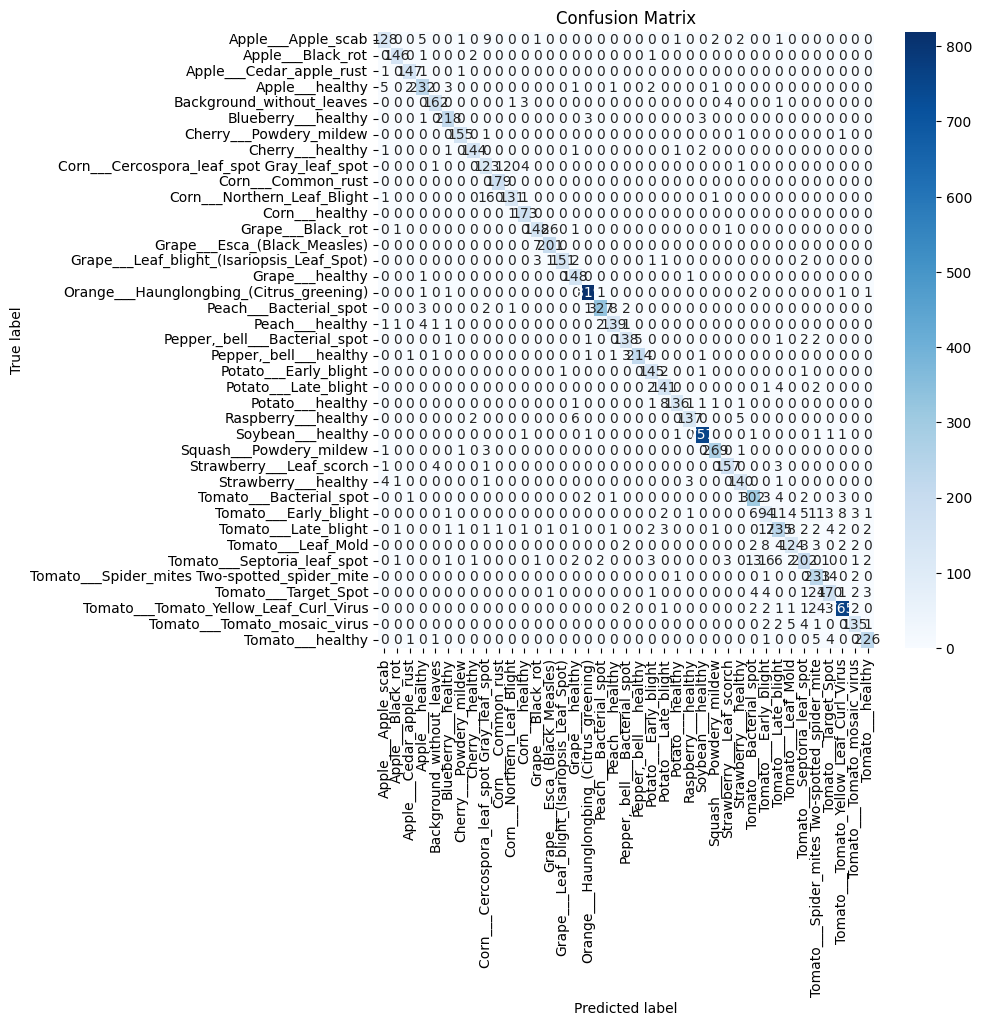

Overall Accuracy: 0.9315

Metrics by Class:
Class                Accuracy   Precision  Recall    
Apple___Apple_scab   0.8533     0.8951     0.8533    
Apple___Black_rot    0.9733     0.9669     0.9733    
Apple___Cedar_apple_rust 0.9800     0.9671     0.9800    
Apple___healthy      0.9393     0.9317     0.9393    
Background_without_leaves 0.9474     0.9529     0.9474    
Blueberry___healthy  0.9689     0.9561     0.9689    
Cherry___Powdery_mildew 0.9810     0.9748     0.9810    
Cherry___healthy     0.9600     0.9664     0.9600    
Corn___Cercospora_leaf_spot Gray_leaf_spot 0.8200     0.7834     0.8200    
Corn___Common_rust   1.0000     0.9890     1.0000    
Corn___Northern_Leaf_Blight 0.8733     0.8506     0.8733    
Corn___healthy       0.9943     0.9454     0.9943    
Grape___Black_rot    0.8362     0.9250     0.8362    
Grape___Esca_(Black_Measles) 0.9663     0.8739     0.9663    
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) 0.9379     0.9934     0.9379    
Grape___healthy      

0.9314756586793885

In [16]:
evaluate_model('best_models/h1_50-35-15_classifierA.pth', val_loader, device)